In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchvision.models import *

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [36]:
# general settings

# device
device = torch.device('cuda' if use_gpu else 'cpu')

# batchsize
batchsize = 64

# seed setting (warning : cuDNN's randomness is remaining)
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)
    
# directory settings
# Data directory (for IR-MNIST)
data_dir = '../../data/IR-MNIST/'
train_data_dir = data_dir + 'Train_Samples/'
test_data_dir = data_dir + 'Test_Samples/'

# directory to put generated images
output_dir = data_dir + 'output/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# directory to save state_dict and loss.npy
save_dir = data_dir + 'save/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [37]:
# make dataset class for image loading
class MyDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_dir = os.listdir(root_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.list_dir)
    
    def __getitem__(self, idx):
        img_name = self.root_dir + self.list_dir[idx]
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [38]:
# define transforms
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# make dataset
imgDataset = MyDataset(train_data_dir, transform = tf)

# split into training data and validation data
train_data, validation_data = train_test_split(imgDataset, test_size = 0.2, random_state = seed)

print('The number of training data:', len(train_data))
print('The number of validation data :', len(validation_data))

The number of training data: 4000
The number of validation data : 1000


In [39]:
# make DataLoader
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batchsize, shuffle = True)

torch.Size([3, 224, 224])


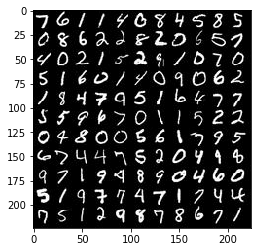

In [40]:
# visualization of an example of training data
# comment out when runnnig in no GUI machine
def show_image(tensor_image):
    np_image = tensor_image.numpy()
    np_image = np.transpose(np_image, [1, 2, 0]) * 0.5 + 0.5
    plt.imshow(np_image)
    
X = iter(train_loader).next()[0]
print(X.size())
show_image(X)

In [41]:
# densenet121 for feature extraction
class mydensenet121(nn.Module):
    def __init__(self):
        super(mydensenet121, self).__init__()
        densenet_pretrained = densenet121(pretrained = True)
        self.features = densenet_pretrained.features[:5]
        self.bn_relu_1x1conv = densenet_pretrained.features[5][:3]
    
    def forward(self, x):
        out = self.features(x)
        out = self.bn_relu_1x1conv(out)
        return out

In [42]:
# define downsampling parts for convenience
class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Downsampler, self).__init__()
        self.cv = nn.Conv2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def forward(self, x):
        out = self.cv(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [43]:
# define upsampling parts for convenience
class Upsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Upsampler, self).__init__()
        self.tc = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def forward(self, x):
        out = self.tc(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [44]:
# define VAE Encoder
class Encoder(nn.Module):
    def __init__(self, n_z):
        super(Encoder, self).__init__()
        self.cv1 = Downsampler(128, 256) # out tensor size : (batchsize, 256, 28, 28)
        self.cv2 = Downsampler(256, 256) # out tensor size : (batchsize, 256, 14, 14)
        self.cv3 = Downsampler(256, 512) # out tensor size : (batchsize, 512,  7,  7)
        
        self.fc4_mean   = nn.Linear(512*7*7, n_z)
        self.fc4_logvar = nn.Linear(512*7*7, n_z)
    
    def forward(self, x):
        out = self.cv1(x)
        out = self.cv2(out)
        out = self.cv3(out)
        
        out = out.view(out.size(0), -1)
        
        out_mean   = self.fc4_mean(out)
        out_logvar = self.fc4_logvar(out)
        
        return out_mean, out_logvar

In [45]:
# define VAE Decoder
class Decoder(nn.Module):
    def __init__(self, n_z):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_z, 512*7*7)
        self.tc2 = Upsampler(512, 256)   # out tensor size : (batchsize, 256, 14, 14)
        self.tc3 = Upsampler(256, 256)   # out tensor size : (batchsize, 256, 28, 28)
        self.tc4_mean    = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1) # (bsize, 128, 56, 56)
        self.tc4_logvar  = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1) # (bsize, 128, 56, 56)
    
    def forward(self, x):
        out = self.fc1(x)
        
        out = out.view(out.size(0), 512, 7, 7)
        
        out = self.tc2(out)
        out = self.tc3(out)
        out_mean = self.tc4_mean(out)
        out_logvar  = self.tc4_logvar(out)
        
        return out_mean, out_logvar

In [46]:
class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        self.encoder = Encoder(n_z)
        self.decoder = Decoder(n_z)
        
    def forward(self, x):
        embed_mean, embed_logvar = self.encoder(x)
        
        eps = torch.randn(embed_mean.size()).to(device)
        z = (0.5 * embed_logvar).exp() * eps + embed_mean
        
        out_mean, out_logvar = self.decoder(z)
        
        return out_mean, out_logvar, embed_mean, embed_logvar

In [47]:
# prepare network and optimizer
n_z = 500
net = VAE(n_z)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay = 0.001)
                       
# counting trainable parameters in model
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

# モデルの構造、オプティマイザの表示
print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 45527272

Model:
 VAE(
  (encoder): Encoder(
    (cv1): Downsampler(
      (cv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (cv2): Downsampler(
      (cv): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (cv3): Downsampler(
      (cv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (fc4_mean): Linear(in_features=25088, out_features=500, bias=True)
    (fc4_logvar): Linear(in_features=25088, out_features=500, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=500, out_features=25088, bias=True)
    (tc2): Upsamp

In [48]:
# prepare feature extractor
feature_extractor = mydensenet121()
feature_extractor.to(device)
num_trainable_params = sum(p.numel() for p in feature_extractor.parameters() if p.requires_grad)

print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', feature_extractor)

/home/kaito/.local/lib/python3.5/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


The number of trainable parameters: 377856

Model:
 mydensenet121(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tru

In [49]:
# define loss functions
def loss_D(embed_mean, embed_logvar):
    loss_d = 0.5 * torch.sum(-embed_logvar - 1 + embed_logvar.exp() + embed_mean.pow(2))
    return loss_d

def loss_A(out_logvar):
    log2pi = float(np.log(2*np.pi))
    loss_a = 0.5 * torch.sum(log2pi + out_logvar)
    return loss_a
    
def loss_M(out_mean, out_logvar, in_x):
    loss_m = 0.5 * torch.sum( (out_mean - in_x).pow(2) / out_logvar.exp() )
    return loss_m

In [50]:
# the function run training for 1 epoch
def train(train_loader):
    net.train()
    feature_extractor.eval()
    
    running_D_loss = 0
    running_A_loss = 0
    running_M_loss = 0
    
    for inputs in train_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            inputs = feature_extractor(inputs)
            
        out_mean, out_logvar, embed_mean, embed_logvar = net(inputs)
        loss_d = loss_D(embed_mean, embed_logvar)
        loss_a = loss_A(out_logvar)
        loss_m = loss_M(out_mean, out_logvar, inputs)
        loss = loss_d + loss_a + loss_m
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_D_loss += loss_d.item()
        running_A_loss += loss_a.item()
        running_M_loss += loss_m.item()
        
    average_D_loss = running_D_loss / len(train_loader.dataset)
    average_A_loss = running_A_loss / len(train_loader.dataset)
    average_M_loss = running_M_loss / len(train_loader.dataset)
    
    return average_D_loss, average_A_loss, average_M_loss

In [51]:
def validation(validation_loader):
    net.eval()
    feature_extractor.eval()
    
    running_D_loss = 0
    running_A_loss = 0
    running_M_loss = 0
    
    with torch.no_grad():
        for inputs in validation_loader:
            inputs = inputs.to(device)
            inputs = feature_extractor(inputs)
            out_mean, out_logvar, embed_mean, embed_logvar = net(inputs)
            loss_d = loss_D(embed_mean, embed_logvar)
            loss_a = loss_A(out_logvar)
            loss_m = loss_M(out_mean, out_logvar, inputs)
            
            running_D_loss += loss_d.item()
            running_A_loss += loss_a.item()
            running_M_loss += loss_m.item()
            
    average_D_loss = running_D_loss / len(validation_loader.dataset)
    average_A_loss = running_A_loss / len(validation_loader.dataset)
    average_M_loss = running_M_loss / len(validation_loader.dataset)
    
    return average_D_loss, average_A_loss, average_M_loss

In [52]:
n_epochs = 50
train_loss_list = [[],[],[]]
validation_loss_list = [[],[],[]]
overfit = False
former_validation_loss = 1e10

for epoch in range(n_epochs):
    train_D_loss, train_A_loss, train_M_loss = train(train_loader)
    validation_D_loss, validation_A_loss, validation_M_loss = validation(validation_loader)
    
    train_loss_list[0].append(train_D_loss)
    train_loss_list[1].append(train_A_loss)
    train_loss_list[2].append(train_M_loss)

    validation_loss_list[0].append(validation_D_loss)
    validation_loss_list[1].append(validation_A_loss)
    validation_loss_list[2].append(validation_M_loss)
   
    train_loss = train_D_loss + train_A_loss + train_M_loss
    validation_loss = validation_D_loss + validation_A_loss + validation_M_loss
    
    print('epoch[%d/%d] train_loss:%1.4f validation_loss:%1.4f' %(epoch+1, n_epochs, train_loss, validation_loss))
    
    if former_validation_loss < validation_loss:
        if overfit:
            print('early stopping')
            break
        else:
            overfit = True
    else:
        overfit = False
    
    former_validation_loss = validation_loss
        
    
np.save(save_dir + 'train_loss_list_use_densenet121.npy', np.array(train_loss_list))
np.save(save_dir + 'validation_loss_list_use_densenet121.npy', np.array(validation_loss_list))

torch.save(net.state_dict(), save_dir + 'VAE_IR_MNIST_use_densenet121.pth')

epoch[1/50] train_loss:-57686.9657 validation_loss:-221157.1332
epoch[2/50] train_loss:-238776.9083 validation_loss:-242145.6517
epoch[3/50] train_loss:-250341.1410 validation_loss:-248034.6482
epoch[4/50] train_loss:-255156.5285 validation_loss:-255341.1491
epoch[5/50] train_loss:-257602.8609 validation_loss:-257584.7243
epoch[6/50] train_loss:-260230.1021 validation_loss:-261183.0736
epoch[7/50] train_loss:-265574.0459 validation_loss:-267319.8513
epoch[8/50] train_loss:-273114.1786 validation_loss:-277917.5421
epoch[9/50] train_loss:-282979.6877 validation_loss:-285736.3572
epoch[10/50] train_loss:-291162.7917 validation_loss:-291832.0883
epoch[11/50] train_loss:-295669.9748 validation_loss:-295791.6299
epoch[12/50] train_loss:-299560.3373 validation_loss:-298499.3811
epoch[13/50] train_loss:-303402.1796 validation_loss:-301611.6942
epoch[14/50] train_loss:-306818.6436 validation_loss:-304390.9216
epoch[15/50] train_loss:-311801.4392 validation_loss:-309496.5074
epoch[16/50] train_l